In [29]:
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import pyolim
import skimage.transform

# Load and scale Marmousi velocity model

The Marmousi model stores a velocity in [m/s]. The model is 9.2km long and 3km deep.

In [2]:
with np.load('marmousi.npz') as data:
    F = data['F']

Convert to [km/s].

In [3]:
F /= 1000

Define Z and X coordinates in [m]

In [92]:
xmin, xmax, nx = 0.0, 9.2, F.shape[1]
zmin, zmax, nz = 0.0, 3.0, F.shape[0]
X, Z = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(zmin, zmax, nz))

Plot model with units (recreate plot from [here](http://www.reproducibility.org/RSF/book/data/marmousi/paper_html/node2.html))

In [123]:
figsize = (14, 4) # We'll use this size below, so store it here
cmap = cc.cm.bmy # Pick a nice colormap

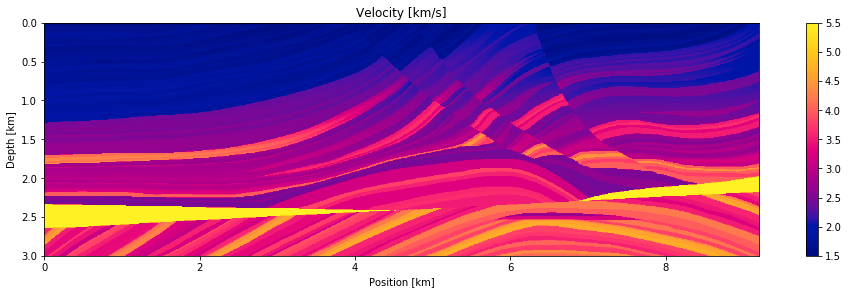

In [124]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(F, cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_aspect('equal')
ax.set_title('Velocity [km/s]')
fig.colorbar(im, ax=ax)
fig.tight_layout()

# Upsample and downsample

In [13]:
bigger_levels, smaller_levels = 3, 3
Fs = [F]

print('- upsampling')
for l in range(bigger_levels):
    Fs.append(skimage.transform.rescale(Fs[-1], 2, mode='constant', multichannel=False))
Fs = list(reversed(Fs))
print('- downsampling')
for l in range(smaller_levels):
    Fs.append(skimage.transform.rescale(Fs[-1], 0.5, mode='constant', multichannel=False))
Fs = list(reversed(Fs))

In [16]:
levels = len(Fs)
for level in range(levels):
    print('level %d: shape = %s' % (level, Fs[level].shape))

level 0: shape = (94, 288)
level 1: shape = (188, 575)
level 2: shape = (376, 1150)
level 3: shape = (751, 2301)
level 4: shape = (1502, 4602)
level 5: shape = (3004, 9204)
level 6: shape = (6008, 18408)


# Convert to slowness for use with `pyolim`

In [20]:
Ss = [1/F for F in Fs]

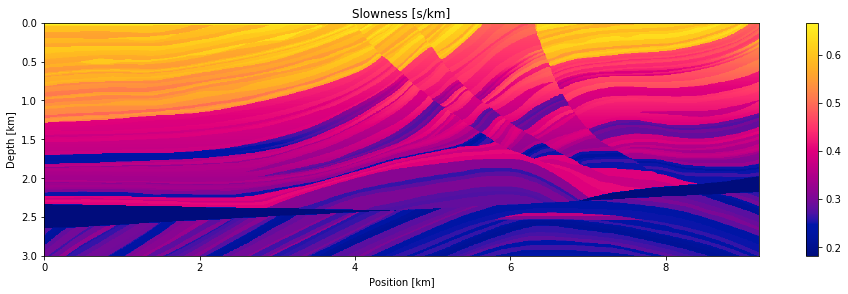

In [108]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(Ss[3], cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_aspect('equal')
ax.set_title('Slowness [s/km]')
fig.colorbar(im, ax=ax)
fig.tight_layout()

# Solve some test problems

In [118]:
level = 2
S = Ss[level]
nz, nx = S.shape
X, Z = np.meshgrid(np.linspace(xmin, xmax, nx), np.linspace(zmin, zmax, nz))
h = zmax/(nz - 1)

### Compute first arrival times for a single point source

In [119]:
nb = pyolim.Neighborhood.OLIM8
quad = pyolim.Quadrature.MP0
olim = pyolim.Olim(nb, quad, S, h)
olim.add_src((0, 0))
olim.solve()

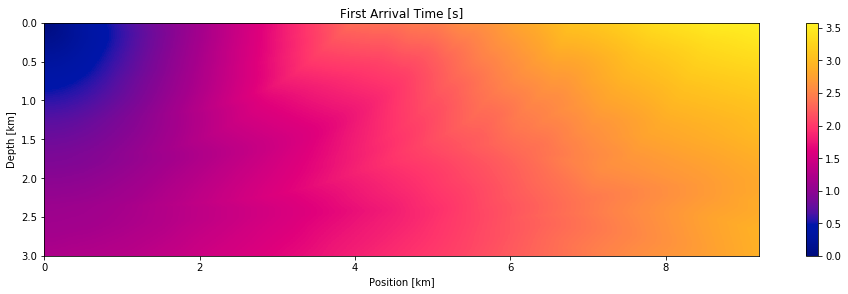

In [120]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(olim.U, cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_title('First Arrival Time [s]')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
fig.tight_layout()

### Compute first arrival times from the surface

In [121]:
nb = pyolim.Neighborhood.OLIM8
quad = pyolim.Quadrature.MP0
olim = pyolim.Olim(nb, quad, S, h)
for j in range(nx):
    olim.add_src((0, j))
olim.solve()

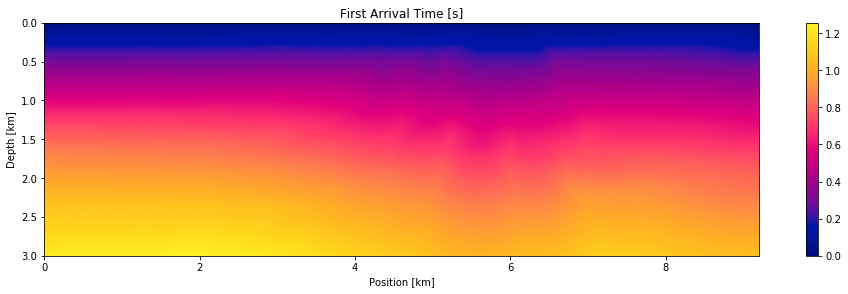

In [125]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
im = ax.imshow(olim.U, cmap=cmap, extent=[xmin, xmax, zmax, zmin])
ax.set_ylabel('Depth [km]')
ax.set_xlabel('Position [km]')
ax.set_title('First Arrival Time [s]')
ax.set_aspect('equal')
fig.colorbar(im, ax=ax)
fig.tight_layout()